In [1]:
import os
from scipy import stats
import dask.array as da
import zarr
import matplotlib.pyplot as plt

from tensorflow import math
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
!ls ../data

db_anytown_doe_pumpfed_1  db_ctown_doe_pumpfed_1  db_richmond_doe_pumpfed_1


In [3]:
store = zarr.open('../data/db_richmond_doe_pumpfed_1', mode='r')
store.info

Name,/
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,3
No. arrays,0
No. groups,3
Groups,"trn, tst, vld"


In [4]:
class ReconstructionLoss():
    def __init__(self, var_range, var_min):
        self.range  = var_range
        self.min    = var_min

    def _difference(self, y_true, y_pred):
        return math.subtract(y_true, y_pred)

    def _rescale(self, data):
        return math.add(
                math.multiply(
                    data,
                    self.range
                    ),
                self.min
                )

    def absolute_error(self, y_true, y_pred):
        abs_err = math.abs(
                    math.subtract(
                        #self._rescale(y_true),
                        y_true,
                        self._rescale(y_pred)
                        )
                    )
        return math.reduce_mean(abs_err, axis=None)

    def relative_error(self, y_true, y_pred):
        #y_true  = self._rescale(y_true)
        y_pred  = self._rescale(y_pred)
        err     = self._difference(y_true, y_pred)
        rel_err = math.abs(math.divide_no_nan(err, y_true))
        return math.reduce_mean(rel_err, axis=None)

In [5]:
junc_dmds = da.from_zarr(url=store['trn']['x']['junc_demands'])
pflows = da.from_zarr(url=store['trn']['y']['pump_flows'])
tflows = da.from_zarr(url=store['trn']['y']['tank_flows'])
junc_heads = da.from_zarr(url=store['trn']['y']['junc_heads'])

dmd_avg = store['trn']['x']['junc_demands'].attrs['avg']
dmd_std = store['trn']['x']['junc_demands'].attrs['std']
pflows_min = store['trn']['y']['pump_flows'].attrs['min']
pflows_range = store['trn']['y']['pump_flows'].attrs['range']
tflows_min = store['trn']['y']['tank_flows'].attrs['min']
tflows_range = store['trn']['y']['tank_flows'].attrs['range']
head_min = store['trn']['y']['junc_heads'].attrs['min']
head_range = store['trn']['y']['junc_heads'].attrs['range']

In [6]:
pflow_losses = ReconstructionLoss(pflows_range, pflows_min)
tflow_losses = ReconstructionLoss(tflows_range, tflows_min)
head_losses = ReconstructionLoss(head_range, head_min)

In [7]:
junc_dmds_rescaled = junc_dmds * dmd_std + dmd_avg
pflows_rescaled = pflows * pflows_range + pflows_min
tflows_rescaled = tflows * tflows_range + tflows_min
junc_heads_rescaled = junc_heads * head_range + head_min

In [8]:
junc_dmds

dask.array<from-zarr, shape=(11998, 865), dtype=float32, chunksize=(10000, 865), chunktype=numpy.ndarray>

In [9]:
pflows

dask.array<from-zarr, shape=(11998, 5), dtype=float32, chunksize=(10000, 5), chunktype=numpy.ndarray>

In [10]:
tflows

dask.array<from-zarr, shape=(11998, 6), dtype=float32, chunksize=(10000, 6), chunktype=numpy.ndarray>

In [11]:
junc_demands_avg = junc_dmds_rescaled.sum(axis=1).mean().compute()
pump_flows_avg = pflows_rescaled.sum(axis=1).mean().compute()
tank_flows_avg = tflows_rescaled.sum(axis=1).mean().compute()
junc_heads_avg = junc_heads_rescaled.mean().compute()

print('Átlagos fogyasztás: {:.1f} m**3/h.'.format(junc_demands_avg))
print('Átlagos szivattyú betáp: {:.1f} m**3/h -- {:.2f} %.'.format(
    pump_flows_avg, pump_flows_avg/junc_demands_avg*100))
print('Átlagos medence betáp: {:.1f} m**3/h. -- {:.2f} %.'.format(
    tank_flows_avg, tank_flows_avg/junc_demands_avg*100))
print('Átlagos csomóponti nyomás {:.1f} m.'.format(junc_heads_avg))

Átlagos fogyasztás: 10.5 m**3/h.
Átlagos szivattyú betáp: 162.8 m**3/h -- 1555.09 %.
Átlagos medence betáp: -52.6 m**3/h. -- -502.38 %.
Átlagos csomóponti nyomás 213.8 m.


Text(0, 0.5, 'Nyomás, m')

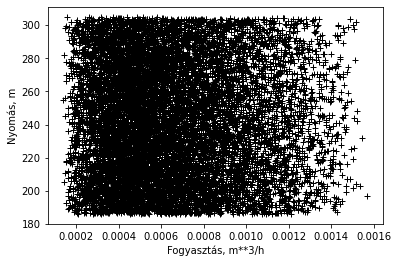

In [12]:
plt.plot(junc_dmds_rescaled[:,0], junc_heads_rescaled[:,8], 'k+')
plt.xlabel('Fogyasztás, m**3/h')
plt.ylabel('Nyomás, m')

In [13]:
head_losses.absolute_error(junc_heads_rescaled, junc_heads).numpy()

0.0

In [14]:
junc_heads_rescaled.std().compute()

33.921467

In [15]:
print(junc_heads_rescaled.min().compute())
print(junc_heads_rescaled.max().compute())

69.98088
329.04767


In [16]:
stats.normaltest(junc_heads_rescaled, axis=None)

NormaltestResult(statistic=852453.8406157743, pvalue=0.0)

In [17]:
#plt.hist(junc_heads)